# Models

Training and testing models: PSSM, HMM and ensemble of both

In [1]:
# Dependencies
import os
import modules.pssm as pssm
import modules.hmm as hmm
from modules.ensemble import majority_voting
import modules.conf_mat as cmat
import modules.pdb as pdb
import modules.tmalign as tmalign
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Set matplotlib inline
%matplotlib inline

In [2]:
# Constants
SEQ_FASTA_PATH = 'data/domain.fasta'  # Input sequence (domain)
BLAST_FASTA_PATH = 'data/blast.fasta'  # Get sequence similarity search result
MSA_FASTA_PATH = 'data/msa.edited.fasta'  # Multiple sequence alignment (.fasta)
HUMAN_CSV_PATH = 'data/human.csv'  # Human proteome .csv dataset
HUMAN_FASTA_PATH = 'data/human.fasta'  # Human proteome .fasta dataset
FAMILIES_CSV_PATH = 'data/families.csv'  # Families .csv dataset
# Hidden Markov Model paths
HMMER_MODEL_PATH = 'models/model.hmm'  # Hidden Markov Model path
# PSSM paths
PSSM_MODEL_PATH = 'models/model.pssm'  # PSSM model path
# Results
PSSM_RESULTS_PATH = 'data/results/pssm.tsv'  # PSSM model results
HMMER_RESULTS_PATH = 'data/results/hmmer.tsv'  # HMMER model results
JACK_RESULTS_PATH = 'data/results/jackhmmer.tsv'  # JACKHMMER model results
ENSEMBLE_RESULTS_PATH = 'data/results/ensemble.tsv'  # Ensemble model result
# SITFTS mapping from pdb to uniprot
SIFTS_CSV_PATH = 'data/pdb/pdb_chain_uniprot.tsv'

In [3]:
# Load protein families dataset
human_proteome = pd.read_csv(HUMAN_CSV_PATH, sep='\t')
human_proteome.head()

,entry_ac,entry_name,protein_name,len,go,pdb_ids,pfam_ids,string_id,PF00397
0,Q9Y263,PLAP_HUMAN,Phospholipase A-2-activating protein (PLA2P) (...,795,cell [GO:0005623]; cell junction [GO:0030054];...,2K89;2K8A;2K8B;2K8C;3EBB;,PF09070;PF08324;PF00400;,9606.ENSP00000380460;,False
1,Q96RE7,NACC1_HUMAN,Nucleus accumbens-associated protein 1 (NAC-1)...,527,cell junction [GO:0030054]; cytoplasm [GO:0005...,3GA1;4U2N;,PF10523;PF00651;,9606.ENSP00000292431;,False
2,O43312,MTSS1_HUMAN,Protein MTSS 1 (Metastasis suppressor YGL-1) (...,755,actin cytoskeleton [GO:0015629]; cytoplasm [GO...,2D1K;,PF08397;PF02205;,9606.ENSP00000322804;,False
3,Q9NP80,PLPL8_HUMAN,Calcium-independent phospholipase A2-gamma (EC...,782,endoplasmic reticulum membrane [GO:0005789]; G...,NaN,PF01734;,9606.ENSP00000410804;,False
4,Q15319,PO4F3_HUMAN,"POU domain, class 4, transcription factor 3 (B...",338,cytoplasm [GO:0005737]; nuclear chromatin [GO:...,NaN,PF00046;PF00157;,9606.ENSP00000230732;,False


In [4]:
# Define function for turning matching ranges into positive positions
def match_to_pos(matches):
    # Define positions container
    positions = list()
    # Check if matches list is empty
    if matches != '':
        # Go through each match
        for dom in matches.split(','):
            # Define start and end of current domain
            dom_start, dom_end = tuple(dom.split('..'))
            # Add current domain's positions
            positions = positions + list(range(int(dom_start), int(dom_end)))
    # Return list of matching positions
    return set(positions)

In [5]:
# Load families positions dataset
protein_matching = pd.read_csv('data/protein_matching.tsv', sep='\t')
protein_matching.columns = ['entry_ac', 'source_db', 'protein_name', 'tax_id',
                              'tax_name', 'len', 'pfam_id', 'matches']
# Take a subset of the original columns
protein_matching = protein_matching[['entry_ac', 'matches']]
# Join protein matching with all the dataset
protein_matching = pd.merge(left=human_proteome[['entry_ac', 'len']],
                            right=protein_matching[['entry_ac', 'matches']],
                            how='left', on='entry_ac')
# Fill na values where there is no domain
protein_matching['matches'] = protein_matching['matches'].fillna('')
# Define real positive matches
protein_matching['positive'] = protein_matching['matches'].apply(match_to_pos)
# Define negative matches
protein_matching['negative'] = protein_matching.apply(lambda x: set(range(1, x['len'])) - x['positive'], axis=1)
# Define a match column: is there the domain in the protein?
protein_matching['match'] = protein_matching.apply(lambda x: len(x['positive']) > 0, axis=1)
# Subset protein matching dataset (only entry with relative positive and negative matches)
protein_matching = protein_matching[['entry_ac', 'match', 'positive', 'negative']]
protein_matching.head()

,entry_ac,match,positive,negative
0,Q9Y263,False,{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,Q96RE7,False,{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,O43312,False,{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,Q9NP80,False,{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,Q15319,False,{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [6]:
# Define set of truly positive protein accessions
positive = set(protein_matching[protein_matching['match']]['entry_ac'])
negative = set(human_proteome['entry_ac']) - positive

print('There are {:d} positive and {:d} negative proteins in human proteome'.format(
    len(positive), len(negative)
))

There are 38 positive and 20329 negative proteins in human proteome


## PSSM model

In [7]:
# Execute PSSM
try:
    # Fit the model
    pssm.fit(blast_path=BLAST_FASTA_PATH, msa_path=MSA_FASTA_PATH, model_path=PSSM_MODEL_PATH)
    # Evaluate the model
    pssm_out = pssm.test(model_path=PSSM_MODEL_PATH, test_path=HUMAN_FASTA_PATH,
                         num_iterations=4, e_value=1e-3)
    # Parse pssm results
    pssm_out = pssm.parse(pssm_out)
    # Add positive matches
    pssm_out['positive'] = pssm_out.apply(lambda x: set(range(int(x.seq_start), int(x.seq_end))), axis=1)
    # pssm_out = pssm_out.groupby('entry_ac').agg({
    #     'positive': lambda x: set.union(*x)
    # }).reset_index()
    
# Catch error
except subprocess.CalledProcessError as e:
    print(e)
    
# Check pssm result
pssm_out.head(5)

,entry_ac,seq_start,seq_end,e_value,positive
0,Q8N3X1,598,629,3.67e-10,"{598, 599, 600, 601, 602, 603, 604, 605, 606, ..."
1,Q8N3X1,220,248,3.73e-04,"{220, 221, 222, 223, 224, 225, 226, 227, 228, ..."
2,Q13526,7,39,1.18e-06,"{7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."
3,Q9BYW2,2391,2421,2.29e-05,"{2391, 2392, 2393, 2394, 2395, 2396, 2397, 239..."
4,O15428,7,39,2.33e-05,"{7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."


In [8]:
# Define set of positive protein accessions
pssm_positive = set(pssm_out['entry_ac'])
pssm_negative = set(human_proteome['entry_ac']) - pssm_positive

print('There are {:d} positive  and {:d} negative proteins matched by PSSM'.format(
    len(pssm_positive), len(pssm_negative)
))

There are 45 positive  and 20322 negative proteins matched by PSSM


In [9]:
# Define dataset of predicted positive rows
pssm_results = human_proteome[human_proteome.entry_ac.isin(pssm_positive)]
# Save results to disk
pssm_results.to_csv(PSSM_RESULTS_PATH, sep='\t', index=False)
# Show some lines
pssm_results.head()

,entry_ac,entry_name,protein_name,len,go,pdb_ids,pfam_ids,string_id,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,True
871,Q9NZC7,WWOX_HUMAN,WW domain-containing oxidoreductase (EC 1.1.1....,414,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,1WMV;,PF00106;PF00397;,9606.ENSP00000457230;,True
966,Q9GZV5,WWTR1_HUMAN,WW domain-containing transcription regulator p...,400,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,5N5R;5N5T;5N5W;5N75;,PF00397;,9606.ENSP00000419465;,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,True
2780,O15428,PINL_HUMAN,Putative PIN1-like protein (Peptidylprolyl cis...,100,cytosol [GO:0005829]; nucleus [GO:0005634]; pe...,NaN,PF00397;,NaN,True


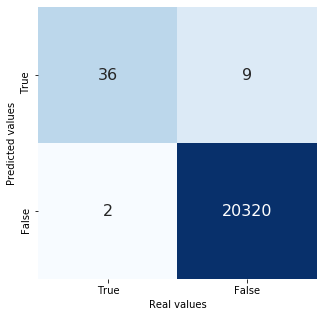

In [10]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=pssm_positive, 
              negative=negative, pred_negative=pssm_negative,
              ax=ax)
_ = plt.show()

## HMMER model

In [11]:
# Execute HMM

# Define e-value threshold
e_value_threshold = 0.7

# Run hmm
try:
    
    # Fit the HMM model
    hmm.fit(msa_path=MSA_FASTA_PATH, model_path=HMMER_MODEL_PATH)
    
    # Evaluate the model
    hmmer_out = hmm.test(test_path=HUMAN_FASTA_PATH, model_path=HMMER_MODEL_PATH, algorithm=hmm.HMMSEARCH)
    hmmer_out = hmm.parse(hmmer_out)
    
    # Make a threshold on e-value
    e_value = hmmer_out['e_value'].astype(float)
    hmmer_out = hmmer_out[e_value < e_value_threshold]
    
    # Add positive matches
    hmmer_out['positive'] = hmmer_out.apply(lambda x: set(range(int(x.seq_start), int(x.seq_end))), axis=1)
    # hmmer_out = hmmer_out.groupby('entry_ac').agg({
    #     'positive': lambda x: set.union(*x)
    # }).reset_index()
        
# Catch error
except subprocess.CalledProcessError as e:
    print(e)
    
# Show dataset
hmmer_out.head(10)

,entry_ac,seq_start,seq_end,e_value,positive
0,Q9H0M0,351,381,0.0016,"{351, 352, 353, 354, 355, 356, 357, 358, 359, ..."
1,Q9H0M0,383,414,0.00069,"{384, 385, 386, 387, 388, 389, 390, 391, 392, ..."
2,Q9H0M0,458,489,0.00016,"{458, 459, 460, 461, 462, 463, 464, 465, 466, ..."
5,Q8N3X1,220,248,0.0019,"{220, 221, 222, 223, 224, 225, 226, 227, 228, ..."
6,Q8N3X1,598,630,1.2e-10,"{598, 599, 600, 601, 602, 603, 604, 605, 606, ..."
8,O00308,315,331,0.041,"{320, 321, 322, 323, 324, 325, 326, 327, 328, ..."
9,O00308,332,363,0.00076,"{332, 333, 334, 335, 336, 337, 338, 339, 340, ..."
10,O00308,407,437,0.00039,"{407, 408, 409, 410, 411, 412, 413, 414, 415, ..."
12,Q96J02,328,358,0.011,"{328, 329, 330, 331, 332, 333, 334, 335, 336, ..."
13,Q96J02,360,390,0.025,"{384, 385, 386, 387, 388, 389, 360, 361, 362, ..."


In [12]:
# Define set of positive protein accessions
hmmer_positive = set(hmmer_out['entry_ac'])
hmmer_negative = set(human_proteome['entry_ac']) - hmmer_positive

print('There are {:d} positive  and {:d} negative proteins matched by HMM'.format(
    len(hmmer_positive), len(hmmer_negative)
))

There are 28 positive  and 20339 negative proteins matched by HMM


In [13]:
# Define dataset of predicted positive rows
hmmer_results = human_proteome[human_proteome.entry_ac.isin(hmmer_positive)]
# Save results to disk
hmmer_results.to_csv(HMMER_RESULTS_PATH, sep='\t', index=False)
# Show some lines
hmmer_results.head()

,entry_ac,entry_name,protein_name,len,go,pdb_ids,pfam_ids,string_id,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,True
2780,O15428,PINL_HUMAN,Putative PIN1-like protein (Peptidylprolyl cis...,100,cytosol [GO:0005829]; nucleus [GO:0005634]; pe...,NaN,PF00397;,NaN,True
3679,Q6AWC2,WWC2_HUMAN,Protein WWC2 (BH-3-only member B) (WW domain-c...,1192,cytosol [GO:0005829]; kinase binding [GO:00199...,NaN,PF00397;,9606.ENSP00000384222;,True
4895,Q9BYW2,SETD2_HUMAN,Histone-lysine N-methyltransferase SETD2 (EC 2...,2564,chromosome [GO:0005694]; nucleoplasm [GO:00056...,2A7O;2MDC;2MDI;2MDJ;4FMU;4H12;5JJY;5JLB;5JLE;5...,PF17907;PF00856;PF08236;PF00397;,9606.ENSP00000386759;,True


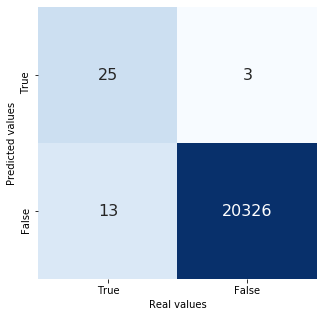

In [14]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=hmmer_positive, 
              negative=negative, pred_negative=hmmer_negative,
              ax=ax)
_ = plt.show()

## JACKHMMER

In [15]:
# Execute HMM

# Define e-value threshold
e_value_threshold = 0.7

# Run hmm
try:
    
    # Evaluate the model
    jack_out = hmm.test(test_path=HUMAN_FASTA_PATH, seq_path=SEQ_FASTA_PATH, algorithm=hmm.JACKHMMER)
    jack_out = hmm.parse(jack_out)
    
    # Make a threshold on e-value
    e_value = jack_out['e_value'].astype(float)
    jack_out = jack_out[e_value < e_value_threshold]
    
    # Add positive matches
    jack_out['positive'] = jack_out.apply(lambda x: set(range(int(x.seq_start), int(x.seq_end))), axis=1)
    # jack_out = jack_out.groupby('entry_ac').agg({
    #     'positive': lambda x: set.union(*x)
    # }).reset_index()
        
# Catch error
except subprocess.CalledProcessError as e:
    print(e)
    
# Show results
jack_out.head(10)

,entry_ac,seq_start,seq_end,e_value,positive
0,Q96PU5,195,224,1.1e-14,"{195, 196, 197, 198, 199, 200, 201, 202, 203, ..."
1,Q96PU5,387,416,6.1e-15,"{387, 388, 389, 390, 391, 392, 393, 394, 395, ..."
2,Q96PU5,499,528,3.3e-16,"{512, 513, 514, 515, 516, 517, 518, 519, 520, ..."
3,Q96PU5,550,579,3.2e-14,"{550, 551, 552, 553, 554, 555, 556, 557, 558, ..."
4,Q9H0M0,351,380,7.9e-16,"{351, 352, 353, 354, 355, 356, 357, 358, 359, ..."
5,Q9H0M0,383,412,1.6e-14,"{384, 385, 386, 387, 388, 389, 390, 391, 392, ..."
6,Q9H0M0,458,487,5.7e-16,"{458, 459, 460, 461, 462, 463, 464, 465, 466, ..."
7,Q9H0M0,498,527,4.6e-13,"{512, 513, 514, 515, 516, 517, 518, 519, 520, ..."
8,O00308,302,331,3.5e-15,"{302, 303, 304, 305, 306, 307, 308, 309, 310, ..."
9,O00308,332,361,8.4e-15,"{332, 333, 334, 335, 336, 337, 338, 339, 340, ..."


In [16]:
# Define set of positive protein accessions
jack_positive = set(jack_out['entry_ac'])
jack_negative = set(human_proteome['entry_ac']) - jack_positive

print('There are {:d} positive  and {:d} negative proteins matched by HMM'.format(
    len(jack_positive), len(jack_negative)
))

There are 49 positive  and 20318 negative proteins matched by HMM


In [17]:
# Define dataset of predicted positive rows
jack_results = human_proteome[human_proteome.entry_ac.isin(jack_positive)]
# Save results to disk
jack_results.to_csv(JACK_RESULTS_PATH, sep='\t', index=False)
# Show some lines
jack_results.head()

,entry_ac,entry_name,protein_name,len,go,pdb_ids,pfam_ids,string_id,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,True
871,Q9NZC7,WWOX_HUMAN,WW domain-containing oxidoreductase (EC 1.1.1....,414,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,1WMV;,PF00106;PF00397;,9606.ENSP00000457230;,True
966,Q9GZV5,WWTR1_HUMAN,WW domain-containing transcription regulator p...,400,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,5N5R;5N5T;5N5W;5N75;,PF00397;,9606.ENSP00000419465;,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,True
2520,Q5VWI1,TCRGL_HUMAN,Transcription elongation regulator 1-like protein,586,nucleus [GO:0005634],NaN,PF01846;,9606.ENSP00000357631;,False


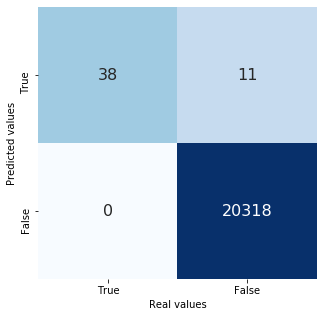

In [18]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=jack_positive, 
              negative=negative, pred_negative=jack_negative,
              ax=ax)
_ = plt.show()

## Ensemble model

Here the ensemble of PSSM and HMM prediction are kept as ensemble model prediction. Then, ensemble model prediction output is evaluated.

In [19]:
# Compute ensemble
ensemble_out = majority_voting([pssm_out, hmmer_out, jack_out], threshold=2)
# ensemble_out = ensemble_out.groupby('entry_ac').agg({
#     'positive': lambda x: set.union(*x)
# }).reset_index()

# Define set of positive protein accessions
ensemble_positive = set(ensemble_out['entry_ac'])
ensemble_negative = set(human_proteome['entry_ac']) - ensemble_positive

print('There are {:d} positive and {:d} negative proteins matched by ensemble method'.format(
    len(ensemble_positive), len(ensemble_negative)
))

There are 51 positive and 20316 negative proteins matched by ensemble method


/home/damiclem/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [20]:
# Define dataset of predicted positive rows
ensemble_results = human_proteome[human_proteome.entry_ac.isin(ensemble_positive)]
# Save results to disk
ensemble_results.to_csv(ENSEMBLE_RESULTS_PATH, sep='\t', index=False)
# Show some lines
ensemble_results.head()

,entry_ac,entry_name,protein_name,len,go,pdb_ids,pfam_ids,string_id,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,True
871,Q9NZC7,WWOX_HUMAN,WW domain-containing oxidoreductase (EC 1.1.1....,414,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,1WMV;,PF00106;PF00397;,9606.ENSP00000457230;,True
966,Q9GZV5,WWTR1_HUMAN,WW domain-containing transcription regulator p...,400,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,5N5R;5N5T;5N5W;5N75;,PF00397;,9606.ENSP00000419465;,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,True
2520,Q5VWI1,TCRGL_HUMAN,Transcription elongation regulator 1-like protein,586,nucleus [GO:0005634],NaN,PF01846;,9606.ENSP00000357631;,False


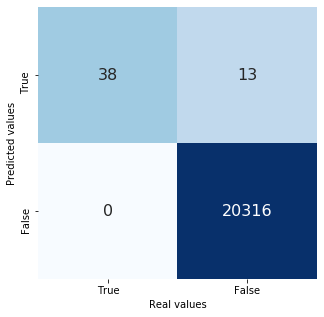

In [21]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=ensemble_positive, 
              negative=negative, pred_negative=ensemble_negative,
              ax=ax)
_ = plt.show()

## Model comparison

Here various metrics are compared for all the different models.

In [22]:
# Define a dictionary model -> predicted positive set
models = {
    'pssm': {
        'positive': pssm_positive, 
        'negative': pssm_negative
    },
    'hmmer': {
        'positive': hmmer_positive,
        'negative': hmmer_negative
    },
    'jackhmmer': {
        'positive': jack_positive,
        'negative': jack_negative
    },
    'ensemble': {
        'positive': ensemble_positive, 
        'negative': ensemble_negative
    }
}

In [23]:
# Compute statistics for each model
for model, attr in models.items():
    # Compute scores for current model (precision, recall, accuracy, weighted accuracy)
    _ , prc, rec, acc, w_acc = cmat.compute(positive=positive, pred_positive=attr['positive'],
                                            negative=negative, pred_negative=attr['negative'])
    # Add scores to each model
    models[model]['prc'] = prc
    models[model]['rec'] = rec
    models[model]['acc'] = acc
    models[model]['w_acc'] = w_acc

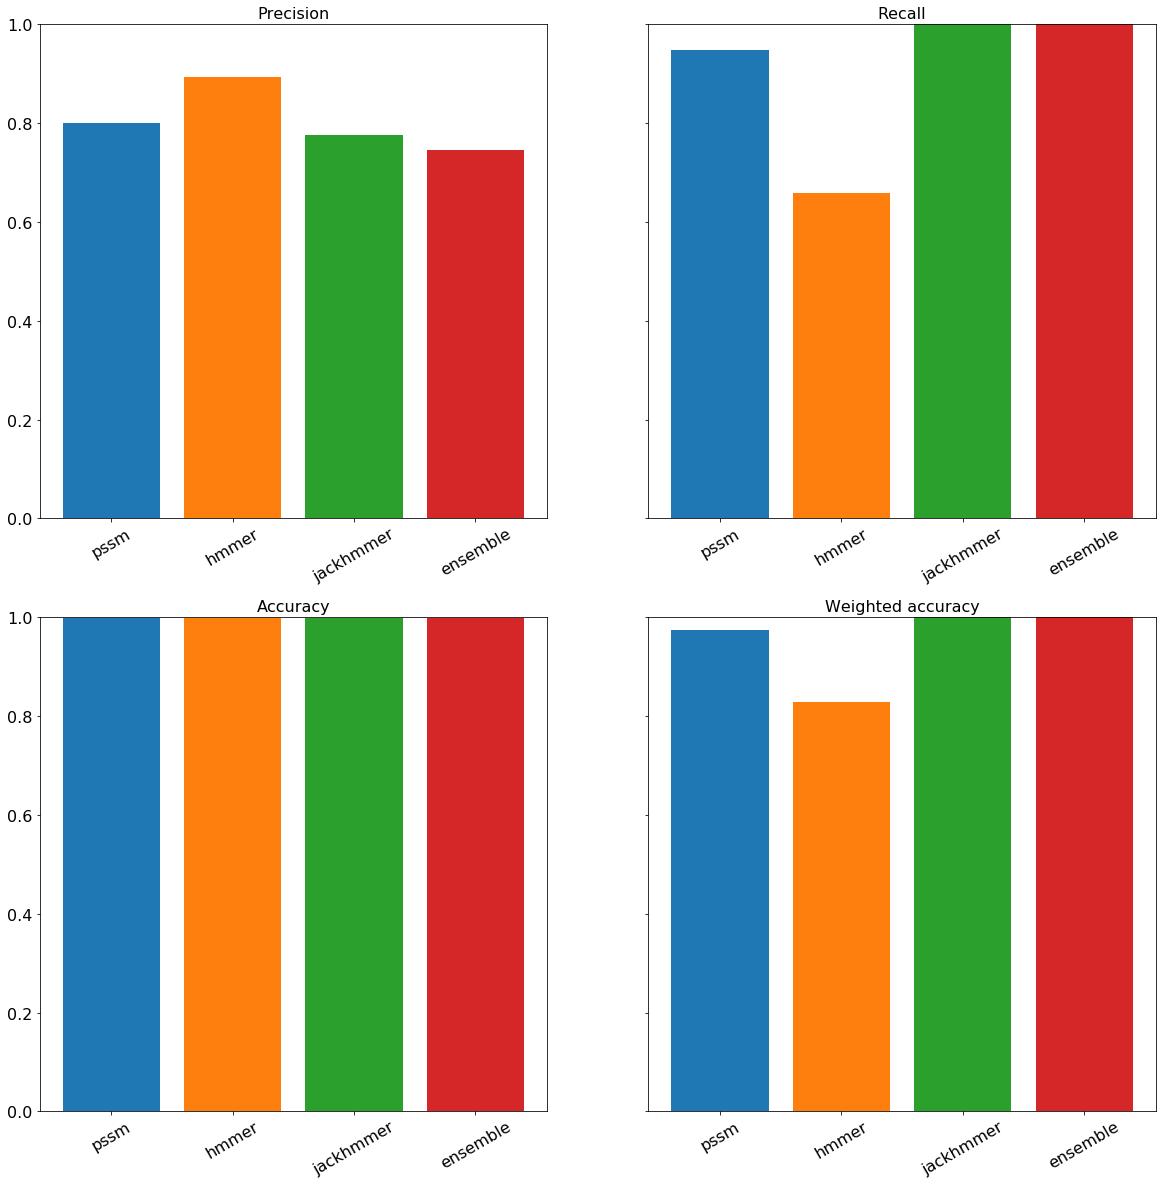

In [54]:
# Show statistics comparison

# Initialize plot: one for each statistic
fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharey=True)
# Flatten axis
axs = axs.flat
# Define titles for each statistic
_ = axs[0].set_title('Precision', fontsize=16)
_ = axs[1].set_title('Recall', fontsize=16)
_ = axs[2].set_title('Accuracy', fontsize=16)
_ = axs[3].set_title('Weighted accuracy', fontsize=16)

# Create a barplot for each statistic
# Fill values for each model
for i, model in enumerate(models.keys()):
    _ = axs[0].bar(i, models[model]['prc'])  # Precision
    _ = axs[1].bar(i, models[model]['rec'])  # Recall
    _ = axs[2].bar(i, models[model]['acc'])  # Accuracy
    _ = axs[3].bar(i, models[model]['w_acc'])  # Weighted accuracy
    
# Set properties for each plot
for i in range(4):
    # Set labels
    _ = axs[i].set_xticks(range(len(models.keys())))
    _ = axs[i].set_xticklabels(list(models.keys()), rotation=30)
    # Set limits
    _ = axs[i].set_ylim(0.0, 1.0)
    # Set axes style
    _ = axs[i].tick_params(labelsize=16)
    
# Show plot
_ = plt.savefig('images/classification.png')
_ = plt.show()

## Sequence matching

In [25]:
# Define different models output
models_out = {
    'pssm': pssm_out,
    'hmmer': hmmer_out,
    'jackhmmer': jack_out,
    'ensemble': ensemble_out
}

In [26]:
# For each model output, define matching sequences

# Define model protein matching container
models_matching = dict()

# loop through each model
for model in models_out.keys():
    
    # Define model output
    model_out = models_out[model]
    
    # Aggregate domains
    model_out = model_out.groupby('entry_ac').agg({
        'positive': lambda x: set.union(*x)
    }).reset_index()

    # Create dataframe for pssm output comparison
    model_matching = pd.merge(left=model_out, right=protein_matching, 
                              how='left', on='entry_ac', suffixes=('_pred', ''))
    # Fill na values with empty sets
    model_matching = model_matching.fillna('').applymap(lambda x: x if x != '' else set())
    # Handle missing values in positive predictions
    model_matching['positive_pred'] = model_matching['positive_pred'].fillna('').apply(lambda x: x if x != '' else set())
    # Add negative predictions
    model_matching['negative_pred'] = model_matching.apply(lambda x: (x['positive'] | x['negative']) - x['positive_pred'], axis=1)
    # Reorder columns
    model_matching = model_matching[['entry_ac', 'positive', 'negative', 'positive_pred', 'negative_pred']]
    
    # Add statistics columns
    # Fill statistics for every row
    for i, row in model_matching.iterrows():
        # Compute all the statistics
        _, prc, rec, acc, w_acc = cmat.compute(positive=row['positive'], pred_positive=row['positive_pred'],
                                               negative=row['negative'], pred_negative=row['negative_pred'])
        # Set values
        # model_matching.loc[i, 'f1s'] = 2 * (prc * rec) / (prc + rec)
        model_matching.loc[i, 'prc'] = prc
        model_matching.loc[i, 'rec'] = rec
        model_matching.loc[i, 'acc'] = acc
        model_matching.loc[i, 'w_acc'] = w_acc
    
    # Store model matching
    models_matching[model] = model_matching

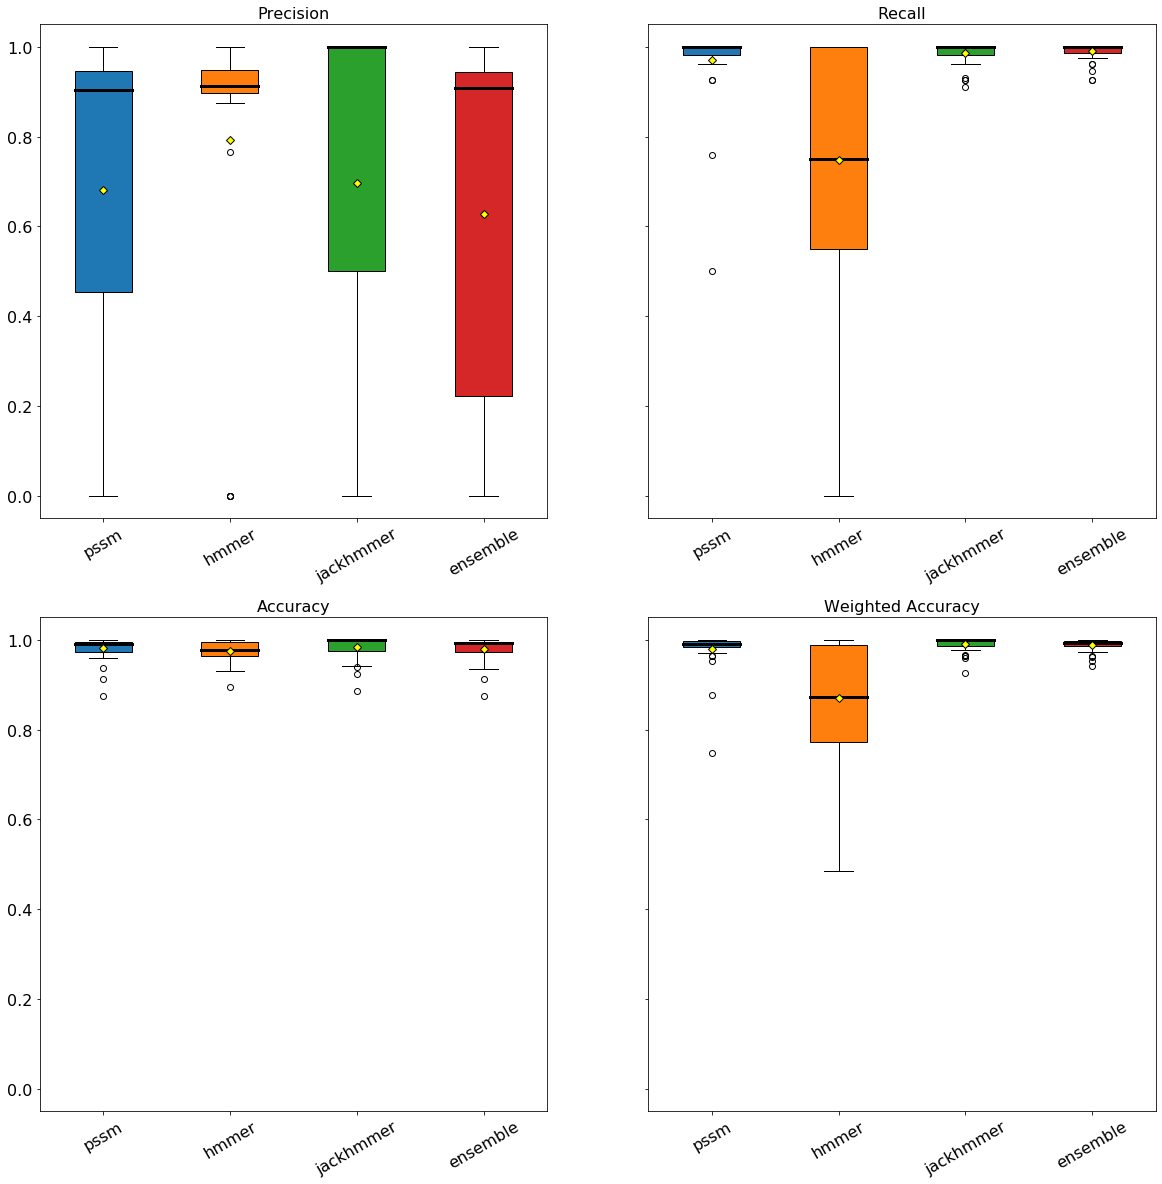

In [57]:
# Show statistics graphically for each model

# Define columns
cols = [('prc', 'Precision'), ('rec', 'Recall'), ('acc', 'Accuracy'), ('w_acc', 'Weighted Accuracy')]

# Define colors
colors = [*mcolors.TABLEAU_COLORS.values()]

# Initialize plots (one for each statistic)
fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharey=True)
axs = axs.flat

# Set plots attributes
for i, col in enumerate(cols):
    # Get stat and title
    stat, title = col
    # Add title
    _ = axs[i].set_title(title, fontsize=16)
    # Create a box for each model
    boxplot = axs[i].boxplot([matching[stat].dropna().tolist() for model, matching in models_matching.items()],
                             medianprops={
                                 'color': 'black',
                                 'linestyle': '-',
                                 'linewidth': 3
                             },
                             meanprops={
                                 'marker': 'D',
                                 'markeredgecolor': 'black',
                                 'markerfacecolor': 'yellow'
                             },
                             meanline=False, showmeans=True, patch_artist=True)
    # Set box labels
    _ = axs[i].set_xticklabels(models_matching.keys(), rotation=30)
    _ = axs[i].tick_params(labelsize=16)
    # Set boxplot colours
    for i, box in enumerate(boxplot['boxes']):
        # Change box color
        box.set_facecolor(colors[i])
        
# Save plot
_ = plt.savefig('images/matching.png')
# Show plot
_ = plt.show()

# Structure matching

In [28]:
# Load SITFS dataset mapping from PDB sequences to UniProt sequences
sifts = pd.read_csv(SIFTS_CSV_PATH, sep='\t', header=1)
# Rename columns
sifts.columns = ['pdb_id', 'chain', 'entry_ac', 'res_beg', 'res_end', 'pdb_beg', 'pdb_end', 'sp_beg', 'sp_end']
# Subset columns:  (keep only pdb id plus the ones mapping to uniprot)
sifts = sifts[['pdb_id', 'chain', 'entry_ac', 'sp_beg', 'sp_end']]
# Rename last columns
sifts.columns = [*sifts.columns[:-2]] + ['seq_start', 'seq_end']
# Group sifts on sequence start and end: various pdb ids map to same areas, but just ine is needed
sifts = sifts.groupby(by=['entry_ac', 'seq_start', 'seq_end']).agg({
    'pdb_id': lambda pdb_ids: pdb_ids.values[0]
}).reset_index()
# Join with human proteome in order to retrieve length of the whole sequence
sifts = sifts.merge(human_proteome[['entry_ac', 'len']], on='entry_ac', how='inner')
# Redefine sequence interval as set of positions
sifts['positive'] = sifts.apply(lambda x: set(range(x['seq_start'], x['seq_end'])), axis=1)
sifts['negative'] = sifts.apply(lambda x: set(range(1, x['len'])) - x['positive'], axis=1)
# Remove useless columns
sifts = sifts[['entry_ac', 'pdb_id', 'positive', 'negative']]
sifts.head()

,entry_ac,pdb_id,positive,negative
0,A0A075B6N1,5hhm,"{21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,A0A075B6N1,5hho,"{21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,A0A075B6N1,5nqk,"{22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,A0A075B6T6,1ao7,"{23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,A0A075B6T6,4zdh,"{24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [29]:
# # Remove redundant PDBs, i.e. the ones which contains other ones
# 
# # Define rows which will be dropped
# drop_rows = set()
# 
# # Group for every accession
# for entry_ac, group in sifts.groupby(by='entry_ac'):
#     # Make a copy of the actual dataset slice
#     group = group.copy()
#     # Sort group by PDB dimension
#     group['pdb_len'] = group['positive'].apply(len)
#     group.sort_values('pdb_len', ascending=False, inplace=True)
#     # Loop through each component of the group
#     # Note: indices are actual sifts dataset indices
#     for i, _  in group.iterrows():
#         # # Define a set of positions covered without i-th rows
#         # positive = set()
#         # Loop through other group's rows
#         for j, _ in group.iterrows():
#             # Skip itself
#             if i == j: continue
#             # If j-th row has been removed: skip it
#             if j in drop_rows: continue
#             # If i-th row is fully contained in j-th, drop i
#             if not len(group.loc[i, 'positive'] - group.loc[j, 'positive']):
#                 drop_rows.add(i)  # Drop row
#             # # Save j-th row positive
#             # positive = positive | group.loc[j, 'positive']
#         # # Check if i-th row can be dropped without losing information
#         # if not len(positive - group.loc[i, 'positive']):
#         #     drop_rows.add(i)  # Drop row
# # Drop rows
# sifts = sifts.drop(list(drop_rows))
# # Show result
# sifts.head()

In [30]:
# Execute HMM

# Run hmm
try:
    
    # Evaluate the model
    model_out = hmm.test(test_path=HUMAN_FASTA_PATH, seq_path=SEQ_FASTA_PATH, algorithm=hmm.JACKHMMER)
    model_out = hmm.parse(model_out)
    
    # Make a threshold on e-value
    e_value = model_out['e_value'].astype(float)
    model_out = model_out[e_value < 0.7]
    
    # Add positive matches
    model_out['positive'] = model_out.apply(lambda x: set(range(int(x.seq_start), int(x.seq_end))), axis=1)
    
    # Get only few column
    model_out = model_out[['entry_ac', 'positive']]
        
# Catch error
except subprocess.CalledProcessError as e:
    print(e)
    
# Show results
jack_out.head(10)

,entry_ac,seq_start,seq_end,e_value,positive
0,Q96PU5,195,224,1.1e-14,"{195, 196, 197, 198, 199, 200, 201, 202, 203, ..."
1,Q96PU5,387,416,6.1e-15,"{387, 388, 389, 390, 391, 392, 393, 394, 395, ..."
2,Q96PU5,499,528,3.3e-16,"{512, 513, 514, 515, 516, 517, 518, 519, 520, ..."
3,Q96PU5,550,579,3.2e-14,"{550, 551, 552, 553, 554, 555, 556, 557, 558, ..."
4,Q9H0M0,351,380,7.9e-16,"{351, 352, 353, 354, 355, 356, 357, 358, 359, ..."
5,Q9H0M0,383,412,1.6e-14,"{384, 385, 386, 387, 388, 389, 390, 391, 392, ..."
6,Q9H0M0,458,487,5.7e-16,"{458, 459, 460, 461, 462, 463, 464, 465, 466, ..."
7,Q9H0M0,498,527,4.6e-13,"{512, 513, 514, 515, 516, 517, 518, 519, 520, ..."
8,O00308,302,331,3.5e-15,"{302, 303, 304, 305, 306, 307, 308, 309, 310, ..."
9,O00308,332,361,8.4e-15,"{332, 333, 334, 335, 336, 337, 338, 339, 340, ..."


In [31]:
# Join model output with sifts
# Note that inner join has been used: we want to get only those PDBs which best match the sequences
structure_matching = pd.merge(left=model_out, right=sifts, how='inner', on='entry_ac', suffixes=('', '_pred'))
structure_matching.columns=['entry_ac', 'positive', 'pdb_id', 'positive_pred', 'negative_pred']
# Add negative column
structure_matching['negative'] = structure_matching.apply(lambda x: (x['positive_pred'] | x['negative_pred']) - x['positive_pred'], axis=1)

# Loop through each row
for i, row in structure_matching.iterrows():
    # Compute statistics
    cm, prc, rec, acc, w_acc = cmat.compute(positive=row['positive'], pred_positive=row['positive_pred'],
                                            negative=row['negative'], pred_negative=row['negative_pred'])
    
    # Get true positive (tp), false positive (fp), true negative (tn), false negative(fn)
    tp, fp, tn, fn = cm[1,0], cm[1,1], cm[0,1], cm[0,0]
    # Save statistics
    structure_matching.loc[i, 'prc'] = prc
    structure_matching.loc[i, 'rec'] = rec
    # structure_matching.loc[i, 'f1s'] = 2 * ((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp)) + (tp / (tp + fn)))

# Compute F1-score
structure_matching['f1s'] = 2 * (structure_matching['prc'] * structure_matching['rec'])
structure_matching['f1s'] = structure_matching['f1s'] / (structure_matching['prc'] + structure_matching['rec'])

# Reorder columns
structure_matching = structure_matching[['entry_ac', 'pdb_id', 'positive', 'negative', 'positive_pred', 'negative_pred', 'prc', 'rec', 'f1s']]
# Show result
structure_matching.head()

,entry_ac,pdb_id,positive,negative,positive_pred,negative_pred,prc,rec,f1s
0,Q96PU5,2nsq,"{195, 196, 197, 198, 199, 200, 201, 202, 203, ...","{154, 155, 156, 157, 158, 159, 160, 161, 162, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{154, 155, 156, 157, 158, 159, 160, 161, 162, ...",NaN,0.0,NaN
1,Q96PU5,2lty,"{195, 196, 197, 198, 199, 200, 201, 202, 203, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{385, 386, 387, 388, 389, 390, 391, 392, 393, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",NaN,0.0,NaN
2,Q96PU5,2lb2,"{195, 196, 197, 198, 199, 200, 201, 202, 203, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{386, 387, 388, 389, 390, 391, 392, 393, 394, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",NaN,0.0,NaN
3,Q96PU5,2laj,"{195, 196, 197, 198, 199, 200, 201, 202, 203, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{512, 513, 514, 515, 516, 517, 518, 519, 520, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",NaN,0.0,NaN
4,Q96PU5,2mpt,"{195, 196, 197, 198, 199, 200, 201, 202, 203, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{512, 513, 514, 515, 516, 517, 518, 519, 520, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",NaN,0.0,NaN


In [32]:
# Get all matching PDBs
pdbs_matching = structure_matching[(structure_matching.rec.isna() != True) & 
                                   (structure_matching.rec >= 0.8)]
pdbs_matching = pdbs_matching.copy()

print('There are {:d} PDBs matching predicted domain'.format(
    pdbs_matching.shape[0])
)

print('There are {:d} proteins which have at least one PDB matching predicted domain'.format(
    pdbs_matching.entry_ac.unique().shape[0]
))

# Show retrieved PDB ids
print('Matching pdb ids are:')
print(','.join(pdbs_matching.pdb_id.unique().tolist()))

There are 77 PDBs matching predicted domain
There are 23 proteins which have at least one PDB matching predicted domain
Matching pdb ids are:
2lty,2lb2,2laj,2mpt,6j1x,6j1y,2op7,6j1z,5tj7,6rss,2dmv,2kyk,5cq2,4rof,5dzd,2ysf,2kpz,2m3o,4n7h,4n7f,2kxq,2djy,5ydx,1k5r,4rex,1jmq,2lax,5ydy,2law,2ltv,3l4h,1wmv,2laz,2lb1,2ltx,2ysd,2zaj,2yse,2mw9,2mwd,2mwf,2dk7,2l5f,1ywi,1zr7,5o9z,2jxw,2dk1,2m8i,1f8a,5b3z,2kbu,2lb3,1i6c,3tcz,2n1o,4qib,2ysg,2ysh,2mdi,2mdc,1eg3,2e45,2ho2,2ysc,2jx8,3le4


In [33]:
# For each structure matching pdb, retrieve the corrisponding pdb file

# Define output path
out_path = 'data/pdb'
out_format = 'pdb'

# Initialize file paths container
pdbs_matching['pdb_file'] = None
# Loop through each row
for i, row in pdbs_matching.iterrows():
    # Get current PDB id
    pdb_id = row['pdb_id']
    # Define path to PDB file
    pdb_path = ''.join([out_path, '/',  pdb_id, '.', out_format])
    # Check if there is the actual PDB file
    if not os.path.exists(pdb_path):
        # Download PDB for current PDB id
        status, pdb_path, _ = pdb.download(pdb_id, out_path=pdb_path, format=out_format, compressed=True)
        # Check response status
        if not status: continue
    # Store downloaded file reference
    pdbs_matching.loc[i, 'pdb_file'] =  pdb_path
    
# Show dataset
pdbs_matching.head()

,entry_ac,pdb_id,positive,negative,positive_pred,negative_pred,prc,rec,f1s,pdb_file
10,Q96PU5,2lty,"{387, 388, 389, 390, 391, 392, 393, 394, 395, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{385, 386, 387, 388, 389, 390, 391, 392, 393, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.0,1.0,data/pdb/2lty.pdb
11,Q96PU5,2lb2,"{387, 388, 389, 390, 391, 392, 393, 394, 395, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{386, 387, 388, 389, 390, 391, 392, 393, 394, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.0,1.0,data/pdb/2lb2.pdb
21,Q96PU5,2laj,"{512, 513, 514, 515, 516, 517, 518, 519, 520, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{512, 513, 514, 515, 516, 517, 518, 519, 520, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.0,1.0,data/pdb/2laj.pdb
22,Q96PU5,2mpt,"{512, 513, 514, 515, 516, 517, 518, 519, 520, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{512, 513, 514, 515, 516, 517, 518, 519, 520, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.0,1.0,data/pdb/2mpt.pdb
41,Q9H0M0,6j1x,"{384, 385, 386, 387, 388, 389, 390, 391, 392, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{379, 380, 381, 382, 383, 384, 385, 386, 387, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.0,1.0,data/pdb/6j1x.pdb


## Structural alignment

In [34]:
# Create a matrix containing RMSD scores for pairwise structural alignments between different PDBs

# Get only passing PDB ids
pdb_files = pdbs_matching['pdb_file']
pdb_files = pdb_files.unique().tolist()

# Compute pairwise alignment among all selected pdb ids
rmsd, tm_score = tmalign.multi_align(pdb_files, script_path=tmalign.SCRIPT_PATH)

### RMSD clustering

In [35]:
# Get RMSD scores head
rmsd.head()

,2lty,2lb2,2laj,2mpt,6j1x,6j1y,2op7,6j1z,5tj7,6rss,...,2ysg,2ysh,2mdi,2mdc,1eg3,2e45,2ho2,2ysc,2jx8,3le4
2lty,0.00,1.54,1.57,1.59,1.54,1.89,2.96,1.56,1.95,1.86,...,1.80,2.37,2.21,2.29,2.36,1.99,1.88,1.73,2.08,1.99
2lb2,1.54,0.00,1.67,1.94,2.40,3.81,2.73,2.43,1.82,2.04,...,2.10,2.42,2.32,3.47,1.86,2.27,1.75,1.84,2.41,2.77
2laj,1.57,1.67,0.00,1.42,2.45,3.58,2.78,1.91,2.36,2.01,...,1.79,2.37,2.07,3.03,1.97,2.16,1.64,1.70,2.78,2.05
2mpt,1.59,1.94,1.42,0.00,1.03,2.11,2.64,0.99,1.69,1.33,...,1.36,2.31,1.15,2.68,1.60,1.52,1.48,1.91,1.88,1.66
6j1x,1.54,2.40,2.45,1.03,0.00,1.61,2.99,1.25,1.58,4.92,...,1.31,1.80,2.95,2.54,5.73,1.60,1.42,1.90,2.18,2.85


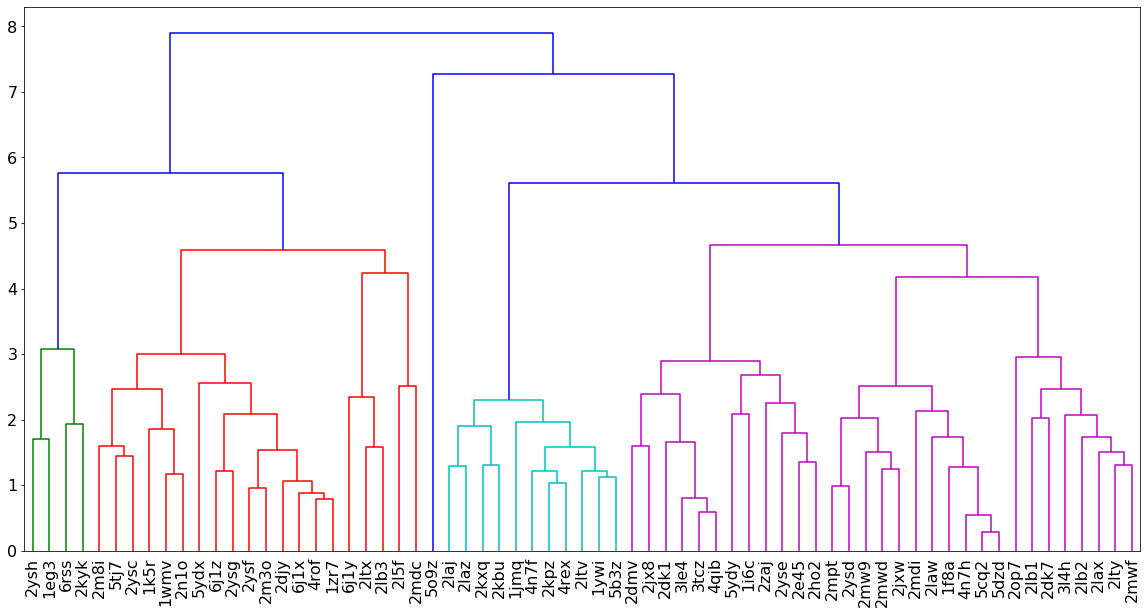

In [58]:
# Show dendrogram for RMSD

# Retrieve matrix dimensions
nrows, ncols = rmsd.shape
# Compute linkage (exclude diagonal)
l = linkage([rmsd.iloc[i, j] for i in range(nrows) for j in range(i+1, ncols)], 'complete')

# Show plot
fig, ax = plt.subplots(figsize=(20, 10))
_ = dendrogram(l, labels=rmsd.columns, ax=ax)
_ = ax.tick_params(axis='both', which='major', labelsize=16)
_ = plt.savefig('images/dendrogram_rmsd.png')
_ = plt.show()

### TM score clustering

In [59]:
# Get TM scores head
tm_score.head()

,2lty,2lb2,2laj,2mpt,6j1x,6j1y,2op7,6j1z,5tj7,6rss,...,2ysg,2ysh,2mdi,2mdc,1eg3,2e45,2ho2,2ysc,2jx8,3le4
2lty,0.00000,0.42919,0.36217,0.38580,0.87379,0.90351,0.63941,0.86301,0.88816,0.66050,...,0.41587,0.48625,0.51782,0.56182,0.80700,0.46992,0.41389,0.35642,0.47344,0.48664
2lb2,0.42919,0.00000,0.41698,0.52160,0.88134,0.89844,0.58231,0.86856,0.89049,0.69165,...,0.55164,0.54275,0.54858,0.64083,0.81049,0.55823,0.48330,0.49184,0.54585,0.57137
2laj,0.36217,0.41698,0.00000,0.39405,0.86810,0.88458,0.65643,0.85885,0.88343,0.66398,...,0.44909,0.52244,0.54522,0.59702,0.79674,0.47759,0.40456,0.45945,0.49815,0.51635
2mpt,0.38580,0.52160,0.39405,0.00000,0.87683,0.90862,0.66538,0.86167,0.88866,0.62999,...,0.35565,0.44092,0.47888,0.57265,0.80653,0.43330,0.37444,0.43681,0.45884,0.48908
6j1x,0.87379,0.88134,0.86810,0.87683,0.00000,0.14037,0.91455,0.11490,0.09330,0.84014,...,0.87279,0.87383,0.88388,0.89815,0.73935,0.87629,0.87847,0.88029,0.87676,0.86134


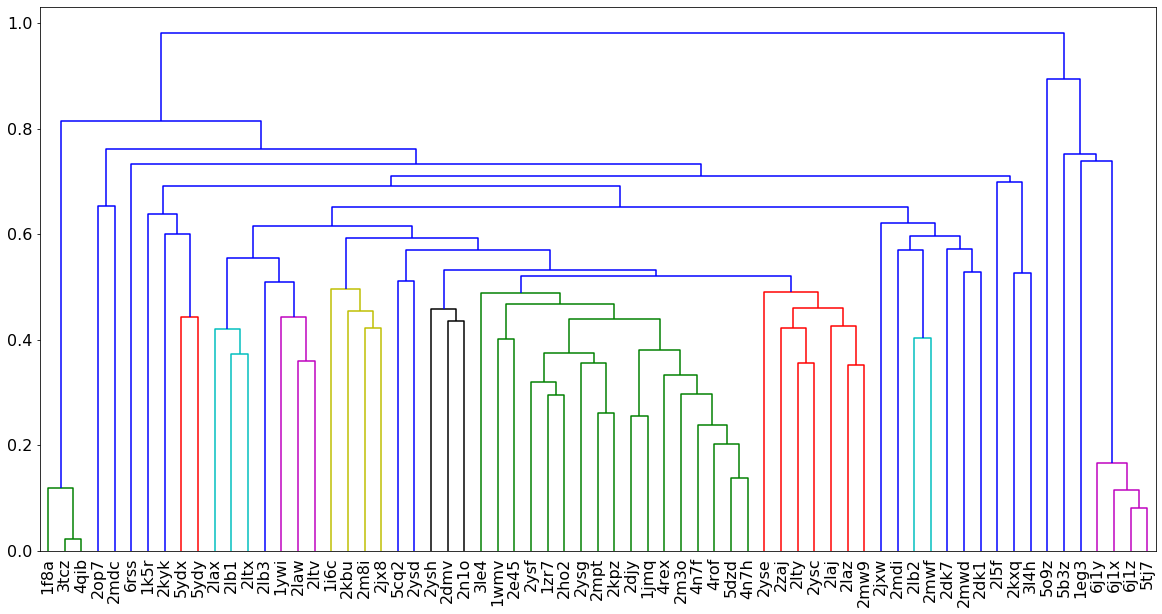

In [60]:
# Show dendrogram for TM score

# Retrieve matrix dimensions
nrows, ncols = tm_score.shape
# Compute linkage (exclude diagonal)
l = linkage([tm_score.iloc[i, j] for i in range(nrows) for j in range(i+1, ncols)], 'complete')

# Show plot
fig, ax = plt.subplots(figsize=(20, 10))
_ = dendrogram(l, labels=tm_score.columns, color_threshold=0.5, ax=ax)
_ = ax.tick_params(axis='both', which='major', labelsize=16)
_ = plt.savefig('images/dendrogram_tmscore.png')
_ = plt.show()